## Repositório

[Tópicos Avançados em Inteligência Computacional 2](https://github.com/Manuelfjr/topicos_avancados_ic_ii/tree/develop)

## Atividade 05

**[PDPs e ICEs]**

descrição:

1. Leia sobre PDPs e ICEs no livro do Molnar, pags 113 a 124. 

2.  Escolha uma base do seu interesse e treine um modelo. Crie gráficos de PDPs e ICEs para as variáveis mais importantes (considerando PFI).

## Introdução

informações: 
A base utilizada será a mesma da atividade `01`.

* **dataset**:  Breast cancer wisconsin (diagnostic)

* **Attribute Information**:
    - radius (mean of distances from center to points on the perimeter)

    - texture (standard deviation of gray-scale values)

    - perimeter

    - area

    - smoothness (local variation in radius lengths)

    - compactness (perimeter^2 / area - 1.0)

    - concavity (severity of concave portions of the contour)

    - concave points (number of concave portions of the contour)

    - symmetry

    - fractal dimension (“coastline approximation” - 1)

The mean, standard error, and “worst” or largest (mean of the three worst/largest values) of these features were computed for each image, resulting in 30 features. For instance, field 0 is Mean Radius, field 10 is Radius SE, field 20 is Worst Radius.

* **class**:
    - WDBC-Malignant (1)
    - WDBC-Benign (0)

## Descrição

Para essa atividade, será selecionado a base de dados da atividade `01` e o melhor modelo obtido, apartir de cross-validaton, utilizado também na atividade `01`, sendo o modelo *Random Forest*.

Será realizado um *Feature Selection* utilizando o *Permutation Feature Importance*, bem como feito na atividade `04`. As *features* selecionadas serão as que apresentam valor **extritamente maior que zero**, levando em consideração que o método avalia utilizando uma métrica a importancia de uma feature, a medida que os valores dela são perturbados aleatoriamente, e então re-avaliada. Apos isso, é avaliado a diferença entre a matrica selecionada do modelo global menos a metrica avaliada sob a base com a *feature* aleatorizada.


## Objetivo

Gerar Visual Plots (PDPs e ICEs) sob a base de dados *breast cancer*, para treinar o modelo *Random Forest*, utilizando as *features* positivas obtidas no *feature selection* do *PFI*.

## 0. Basics

### 0.1 Imports

In [227]:
# datasets
# utils
import warnings
from typing import Any, Dict, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_breast_cancer
# model
from sklearn.ensemble import RandomForestClassifier
# metrics
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.metrics import (accuracy_score, f1_score, make_scorer,
                             precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import cross_val_score, train_test_split
from tqdm import tqdm

warnings.filterwarnings('ignore')

### 0.2 Methods

In [265]:
def func(x: int, a: int = 3, b: int = 3):
    return (x * a) // b


def create_pdp_subplots(
        selected_features: Union[list, np.array],
        model: any,
        X_test_feats: Union[np.array,
        pd.DataFrame],
        corr: bool=True,
        a_: int=16,
        b_: int=16
    ):
    """
    Cria subplots para Gráficos de Dependência Parcial (PDP).

    Parâmetros:
    -----------
    selected_features : Union[list, np.array]
        Lista ou array de características selecionadas.
    model : any
        Modelo de aprendizado de máquina treinado.
    X_test_feats : Union[np.array, pd.DataFrame]
        Matriz de características para dados de teste.
    corr : bool, opcional
        Se deve calcular correlações entre características, por padrão True.

    Retorna:
    --------
    fig_pdp : matplotlib.figure.Figure
        Objeto de figura para os subgráficos PDP.
    axes_pdp : matplotlib.axes.Axes
        Objeto de eixos para os subgráficos PDP.
    """
    if corr:
        X_feats_corr = X_test_feats[selected_features].corr()

    fig_pdp, axes_pdp = plt.subplots(
        len(selected_features),
        len(selected_features),
        figsize=(func(a_, len(selected_features)), func(b_, len(selected_features)))
    )

    for idx_row, i in enumerate(selected_features):
        for idx_col, j in enumerate(selected_features):
            if i != j:
                disp1 = PartialDependenceDisplay.from_estimator(
                    model,
                    X_test_feats,
                    [(i, j)],
                    grid_resolution=20,
                    ax=axes_pdp[idx_row, idx_col]
                )
                if corr:
                    axes_pdp[idx_row, idx_col].set_title("$\\rho_{x,y}$ = " + f"{X_feats_corr.loc[i, j].round(4)}")

    return fig_pdp, axes_pdp


def calculate_metrics(
        model: Any,
        X: Union[pd.DataFrame, pd.Series, np.ndarray],
        y: Union[pd.DataFrame, pd.Series, np.ndarray],
        features: Union[list, np.ndarray],
        which_metrics: Dict[str, Any] = {"accuracy_score": accuracy_score},
        cv: int = 5,
) -> pd.DataFrame:
    """
    Calcula as métricas especificadas usando validação cruzada e retorna um DataFrame.

    Parâmetros:
        model (estimator): O modelo de aprendizado de máquina a ser avaliado.
        X (array-like): As features do conjunto de dados.
        y (array-like): Os rótulos do conjunto de dados.
        cv (int ou iterável): O esquema de validação cruzada a ser utilizado.
        which_metrics (dict): Um dicionário onde as chaves são os nomes das
                                métricas e os valores são as funções de métrica.

    Retorna:
        pd.DataFrame: Um DataFrame contendo as métricas calculadas.

    Exemplo:
        metrics = {
            'accuracy': accuracy_score,
            'precision': precision_score,
            'recall': recall_score
        }
        results = calculate_metrics(model, X, y, cv=5, which_metrics=metrics)
    """
    metrics = {}
    for m, metric in tqdm(which_metrics.items(), desc="Cros-validation"):
        metric = make_scorer(metric)
        value = [float(np.mean(cross_val_score(model, X[features], y, cv=cv, scoring=metric)))]
        metrics[m] = value

    if len(features) == X.shape[1]:
        index_name = ["all_features"]
    else:
        index_name = ["partial_features"]

    results = pd.DataFrame(metrics, index=index_name)
    return results

### 0.3 Parameters

In [229]:
n_seed = 24
n_seed_pfi = 42
cv = 10
n_repeats = 30

In [230]:
params = {
    "holdout": {
        "test_size": 0.3,
        "random_state": 2024
    }
}

In [231]:
which_metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1": f1_score,
    "roc_auc": roc_auc_score
}

## 1. Preparando dataset

### 1.1 Leitura

In [232]:
target = "label"
content = load_breast_cancer()
features = list(content["feature_names"])

### 1.2 Process dataset

In [233]:
data = pd.DataFrame(
    content["data"],
    columns=features
)
data[target] = content["target"]
data.columns = (
    data
    .columns
    .str.replace(" ", "_")
    .str.replace("(", "")
    .str.replace(")", "")
)

### 1.3 Split

In [234]:
X = data.drop(target, axis=1).copy()
y = data[target].values

### 1.4 Holdout

aplicação do processo de holdout, considerando um tamanho de teste de `30%`

In [235]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    **params["holdout"]
)

## 2. Modelagem

### 2.1 Fit 

In [236]:
model = RandomForestClassifier(random_state=n_seed)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=24)

### 2.2 Avaliando

In [237]:
full_model_metrics = calculate_metrics(model, X, y, X.columns, which_metrics=which_metrics, cv=cv)
full_model_metrics

Cros-validation: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


,accuracy,precision,recall,f1,roc_auc
all_features,0.97193,0.9734,0.983175,0.977884,0.968211


## 3. Permutation Feature Importance (PFI)

### 3.1 Full model

In [238]:
result = permutation_importance(
    model,
    X_test,
    y_test,
    n_repeats=n_repeats,
    random_state=n_seed_pfi
)
sorted_idx = result.importances_mean.argsort()
del result["importances"]
result["features"] = X_test.columns
data_result_full = pd.DataFrame(result).set_index(["features"]).sort_values("importances_mean")

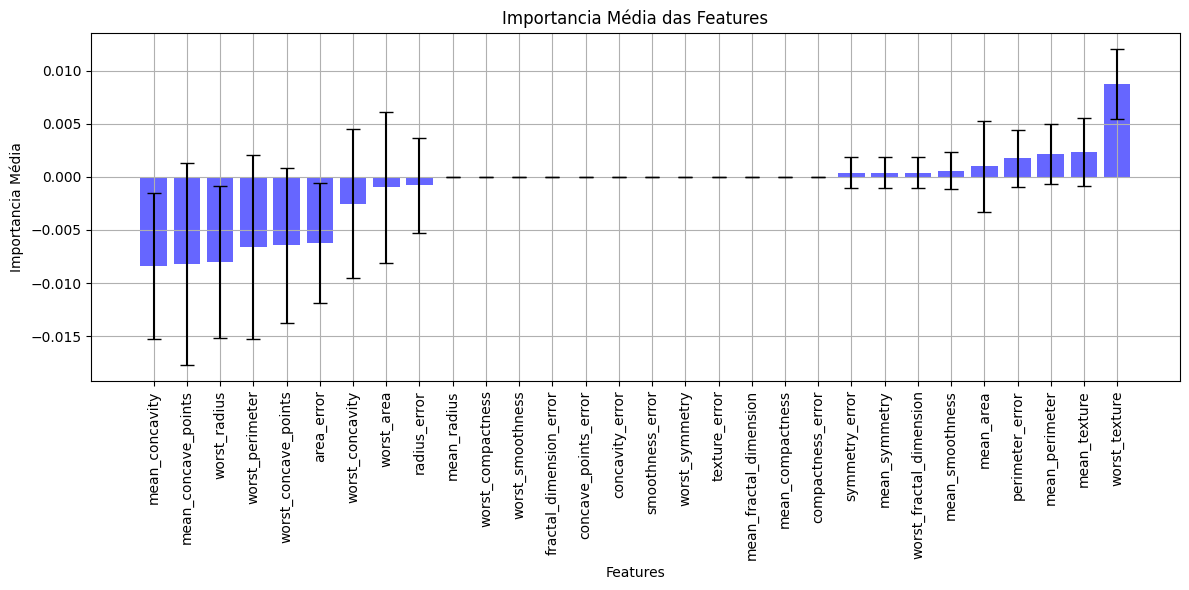

In [239]:
fig_full, axes_full = plt.subplots(1, 1, figsize=(12, 6))
axes_full.bar(
    data_result_full.index,
    data_result_full['importances_mean'],
    color='blue',
    alpha=0.6,
    yerr=data_result_full['importances_std'],
    capsize=5
)
axes_full.set_xlabel('Features')
axes_full.set_ylabel('Importancia Média')
axes_full.set_title('Importancia Média das Features')
axes_full.set_xticklabels(data_result_full.index, rotation=90)
fig_full.tight_layout()
axes_full.grid()
plt.show()

In [240]:
condition = data_result_full["importances_mean"] > 0

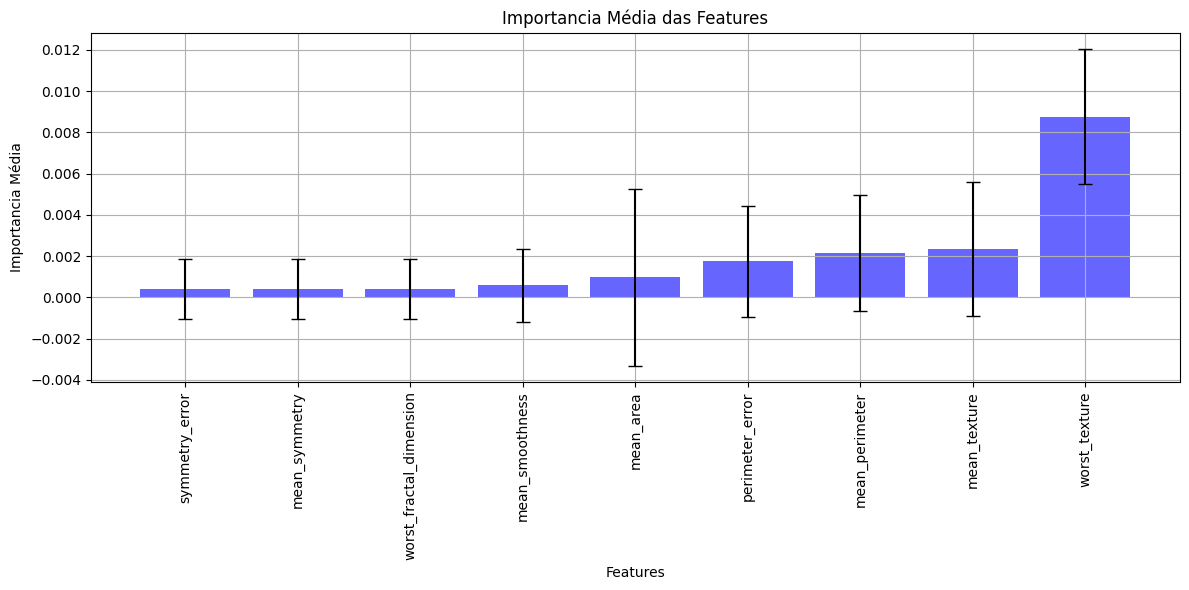

In [241]:
fig_full, axes_full = plt.subplots(1, 1, figsize=(12, 6))
axes_full.bar(
    data_result_full[condition].index,
    data_result_full[condition]['importances_mean'],
    color='blue',
    alpha=0.6,
    yerr=data_result_full[condition]['importances_std'],
    capsize=5
)
axes_full.set_xlabel('Features')
axes_full.set_ylabel('Importancia Média')
axes_full.set_title('Importancia Média das Features')
axes_full.set_xticklabels(data_result_full[condition].index, rotation=90)
fig_full.tight_layout()
axes_full.grid() # 
plt.show()

## 4. Re-treinando modelo com apenas features com importance importantes

### 4.1 Fit

In [242]:
features = data_result_full[condition].index

In [243]:
model = RandomForestClassifier(random_state=n_seed)
model.fit(X_train[features], y_train)

RandomForestClassifier(random_state=24)

### 4.2 Avaliação

In [244]:
partial_model_metrics = calculate_metrics(
    model,
    X,
    y,
    features,
    which_metrics=which_metrics,
    cv=cv
)
partial_model_metrics

Cros-validation: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


,accuracy,precision,recall,f1,roc_auc
partial_features,0.952538,0.956618,0.971984,0.962969,0.946165


In [245]:
results = pd.concat([full_model_metrics, partial_model_metrics]).T

In [246]:
results

,all_features,partial_features
accuracy,0.971930,0.952538
precision,0.973400,0.956618
recall,0.983175,0.971984
f1,0.977884,0.962969
roc_auc,0.968211,0.946165


###  4.3 Analises

|            | **all_features** | **partial_features** |
|------------|--------------|------------------|
| **accuracy**   |   0.971930   |      0.952538    |
| **precision**  |   0.973400   |      0.956618    |
| **recall**     |   0.983175   |      0.971984    |
| **f1**         |   0.977884   |      0.962969    |
| **roc_auc**    |   0.968211   |      0.946165    |


Após analisar os resultados das validações cruzadas para o modelo utilizando todas as variáveis (*full_features*) em comparação com o modelo utilizando apenas as features maiores que zero (*partial_features*), podemos observar que ambos os modelos apresentam desempenho bastante semelhante em termos de métricas de avaliação, como *accuracy*, *precision*, *recall*, *f1* e *roc_auc*.

Isso sugere uma notável robustez do modelo, mesmo após a retirada das *features* que têm importância negativa. O modelo com menos variáveis, que utiliza apenas as que posssuem relevância para a classificação, segundo o *PFI*, mantém um desempenho praticamente proximo ao modelo completo. Essa consistência no desempenho indica que as *features* removidas não contribuem significativamente para a capacidade do modelo de fazer previsões precisas.

Portanto, a capacidade do modelo de manter um desempenho elevado mesmo após a remoção de *features* com baixa importância ressalta sua robustez e capacidade de generalização.  Além disso, apesar do modelo ainda manter uma boa performance apos a retirada das variáveis, ainda houve uma queda das metricas, isso evidencia também que existia alguma relação intrisica das variaveis que foram retiradas para com o target, havendo alguma importância que o método *Permutation Feature Importance* conseguiu mensurar na sua forma de estimação.

## 5 Analise da distribuicao das variaveis

In [247]:
X_test_feats = X[features].copy()

### 5.1 Boxplot

<Axes: >

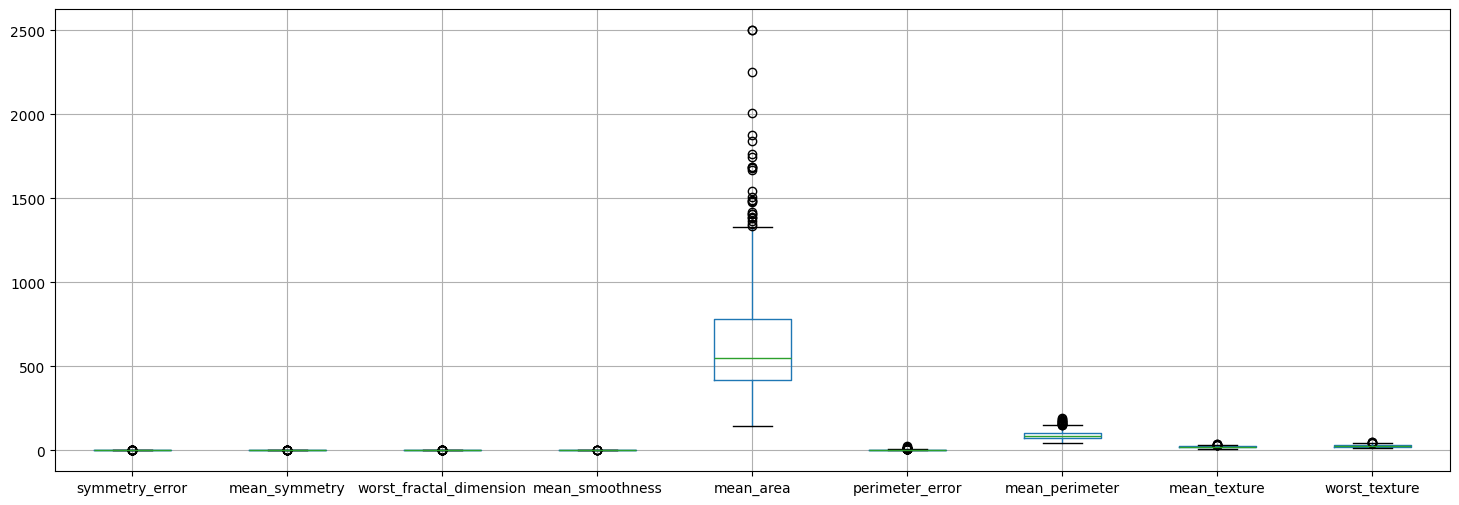

In [248]:
X_test_feats.boxplot(figsize=(18, 6))

É possivel notar que existem variaveis em escalas distintas, dificultando a visualização dos boxplots para analise da distribuicao por variavel. Vamos aplicar uma normalizacao das variaveis para tentar visualizar em conjunto.

In [249]:
X_std = X_test_feats.copy()
for col in X_std.columns:
    X_std[col] = (X_std[col] - X_std[col].mean()) / X_std[col].std()

<Axes: >

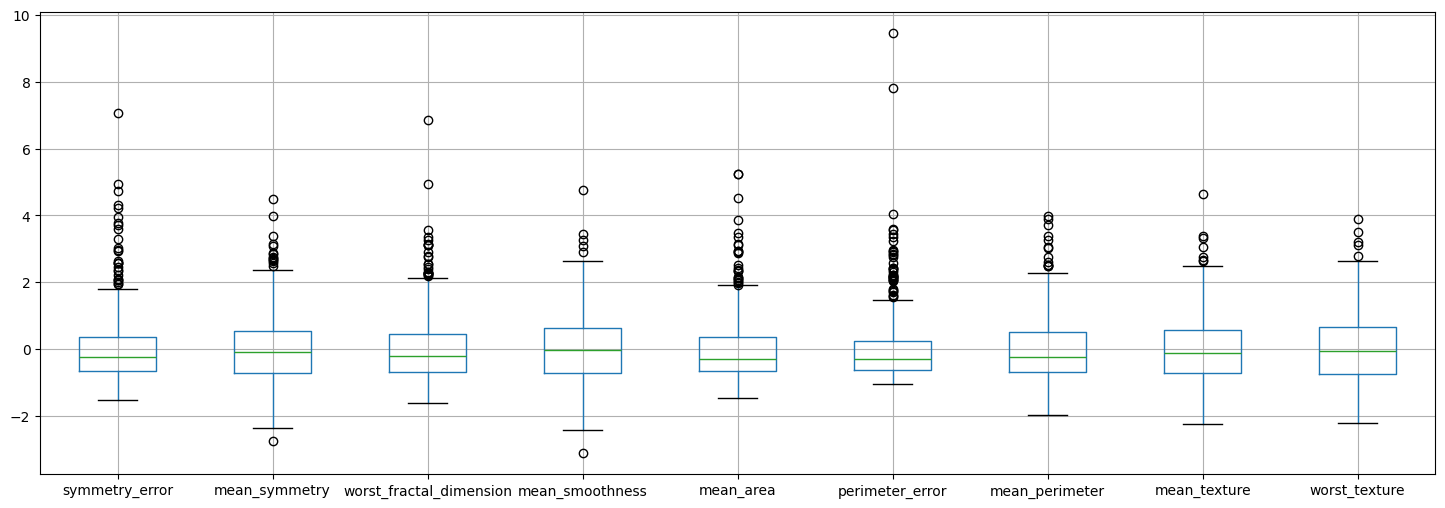

In [250]:
X_std.boxplot(figsize=(18, 6))

Podemos notar que existem todas as variaveis aparentam ter uma distribuição com muitas instâncias outliers superiormente, em especial a mean_area e perimeter_error, apresentando uma baixa variabilidade, com presença de outliers superiores.

### 5.2 Heatmap das correlacoes

<Axes: >

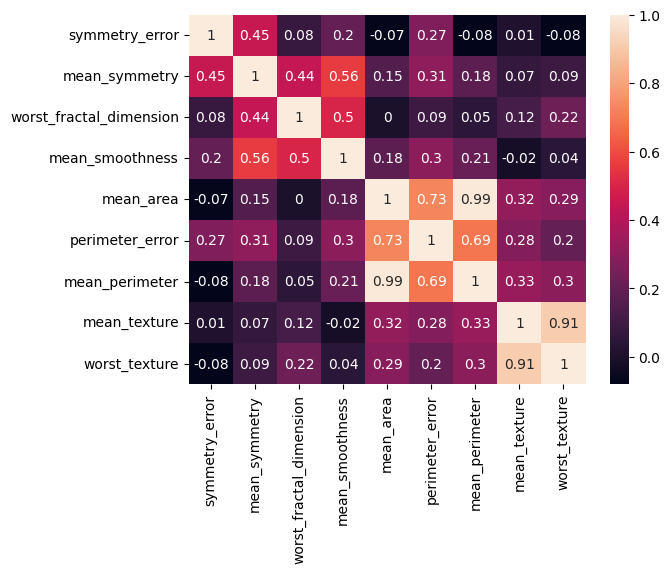

In [251]:
sns.heatmap(X_test_feats.corr().round(2), annot=True)

Acima podemos ver que as variaveis apresentam uma baixa correlação em geral entre elas, com excessão de variaveis que são calculadas em cima da featire respectiva, como a mean_area, perimeter_error e mean_perimeter, alem disso mean_texture com worst_texture.

Essas baixas correlações podem dar mais veracidade aos gráficos *Partial Dependence Plot* (PDPs) e *Individual Conditional Expectation* (ICE).

## 6. Partial Dependence Plot (PDPs)

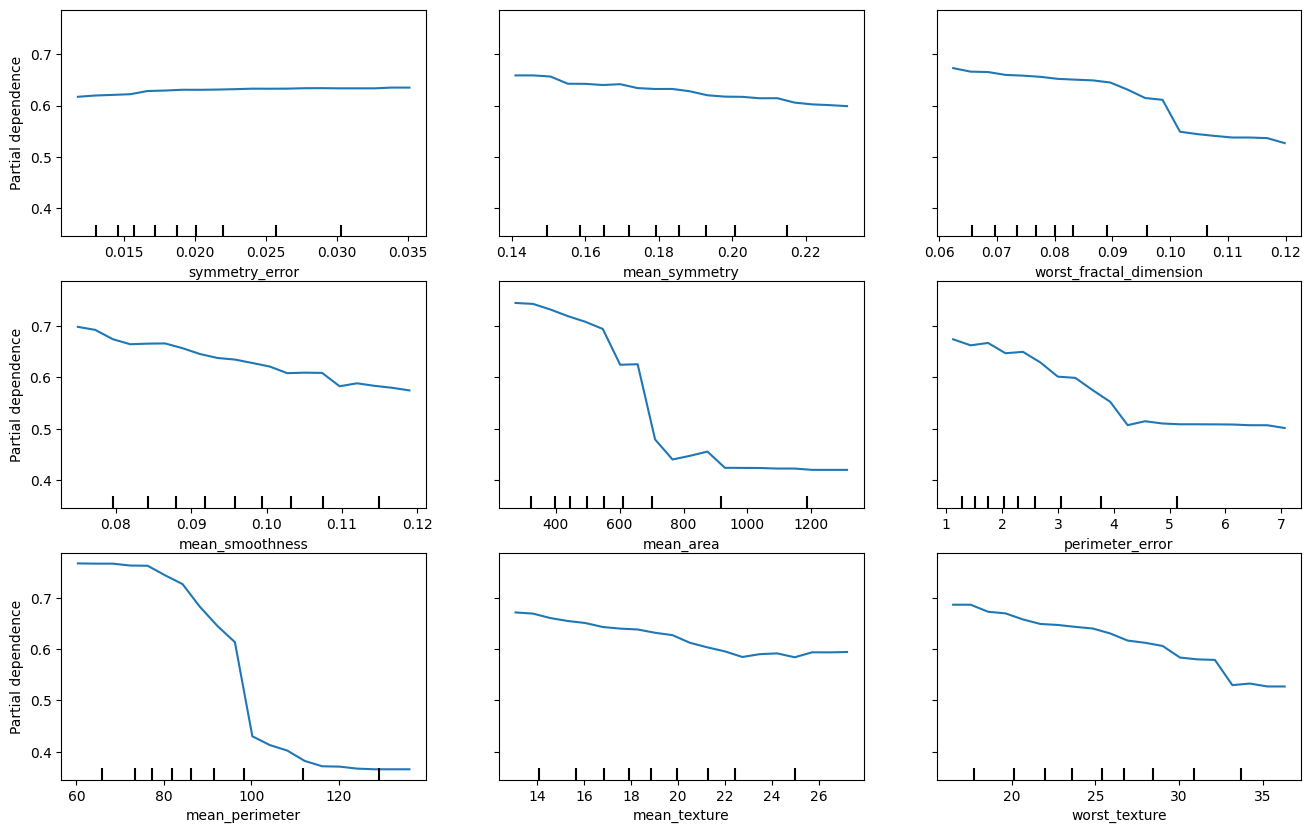

In [252]:
fig_pdp_m1, axes_pdp_m1 = plt.subplots(1, 1, figsize = (16,10))
disp1 = PartialDependenceDisplay.from_estimator(
    model,
    X_test_feats,
    features,
    grid_resolution=20,
    ax=axes_pdp_m1
)

Algumas informações interessantes podem ser obtidas dos graficos acima.

1. As variáveis simmetry_error e mean_symmetry  não aprensenta muita mudança na probabilidade do cancer do individuo ser maligno.

2. Quase todas (com excessão do symmetry_error), mesmo que pequeno, possui um declinio na probabilidade do cancer ser maligno.

3. As proporção de pontos sob o suporte de cada variavel parece bastante balanciada, com excessão do perimeter_error e mean_area.

4. As variaveis worst_texture, mean_perimeter, perimeter_error, mean_area e worst_fractal_dimension apresentam comportamentos interessantes, com quedas acentuadas apartir de um ponto de corte no seu respectivo suporte.
 
    4.1. **worst_texture**: existe uma queda das probabilidade no intervalo de 31 a 34, aproximadamente, e apartir ali em diante as probabilidades de ser maligno fica constantes indicando.

    4.2. **mean_perimeter**: é nitido uma queda bem acentuada da probabilidade do cancer ser maligno, evidenciando que tumores com, em média, um perimetro menor apresenta menores chances de ser maligno.

    4.3. **perimeter_error**: bem como o mean_perimeter, existe uma queda continua ate proximo de um valor de 4, e apartir desse ponto as probabilidades ficam constantes, isso pode se dar por conta da proporcao de instâncias centradas em valores inferiores a 4.

    4.4. **mean_area**: assim ocmo o mean_perimeter, tambem é notavel uma queda acentuada das probabilidades de ser maligno, mas tambem podendo ser ocasionada pela forte presenca de instancias no intervalor inferior a 800.

    4.5. **worst_fractal_dimension**: possui um comportamento analago aos outros, mas com um declineo mais lento, contudo um declive maior proximo do valor de 0.1, e então ficando mais constant. Isso pode ser justificado pela baixa presenca de instancias maiores que 0.1.

In [282]:
selected_features = ["mean_smoothness", "mean_perimeter", "worst_texture", "worst_fractal_dimension", "mean_symmetry"]
X_feats_corr = X_test_feats[selected_features].corr()
X_feats_corr

,mean_smoothness,mean_perimeter,worst_texture,worst_fractal_dimension,mean_symmetry
mean_smoothness,1.000000,0.207278,0.036072,0.499316,0.557775
mean_perimeter,0.207278,1.000000,0.303038,0.051019,0.183027
worst_texture,0.036072,0.303038,1.000000,0.219122,0.090651
worst_fractal_dimension,0.499316,0.051019,0.219122,1.000000,0.438413
mean_symmetry,0.557775,0.183027,0.090651,0.438413,1.000000


Vamos utilizar as variaveis acima para gerar os graficos de PDPs em $\mathbb{R}^{2}$, respeitando a questão da não correlação entre as features, uma vez que isso pode impactar diretamente em analises das regiões de decisão dos PDPs.

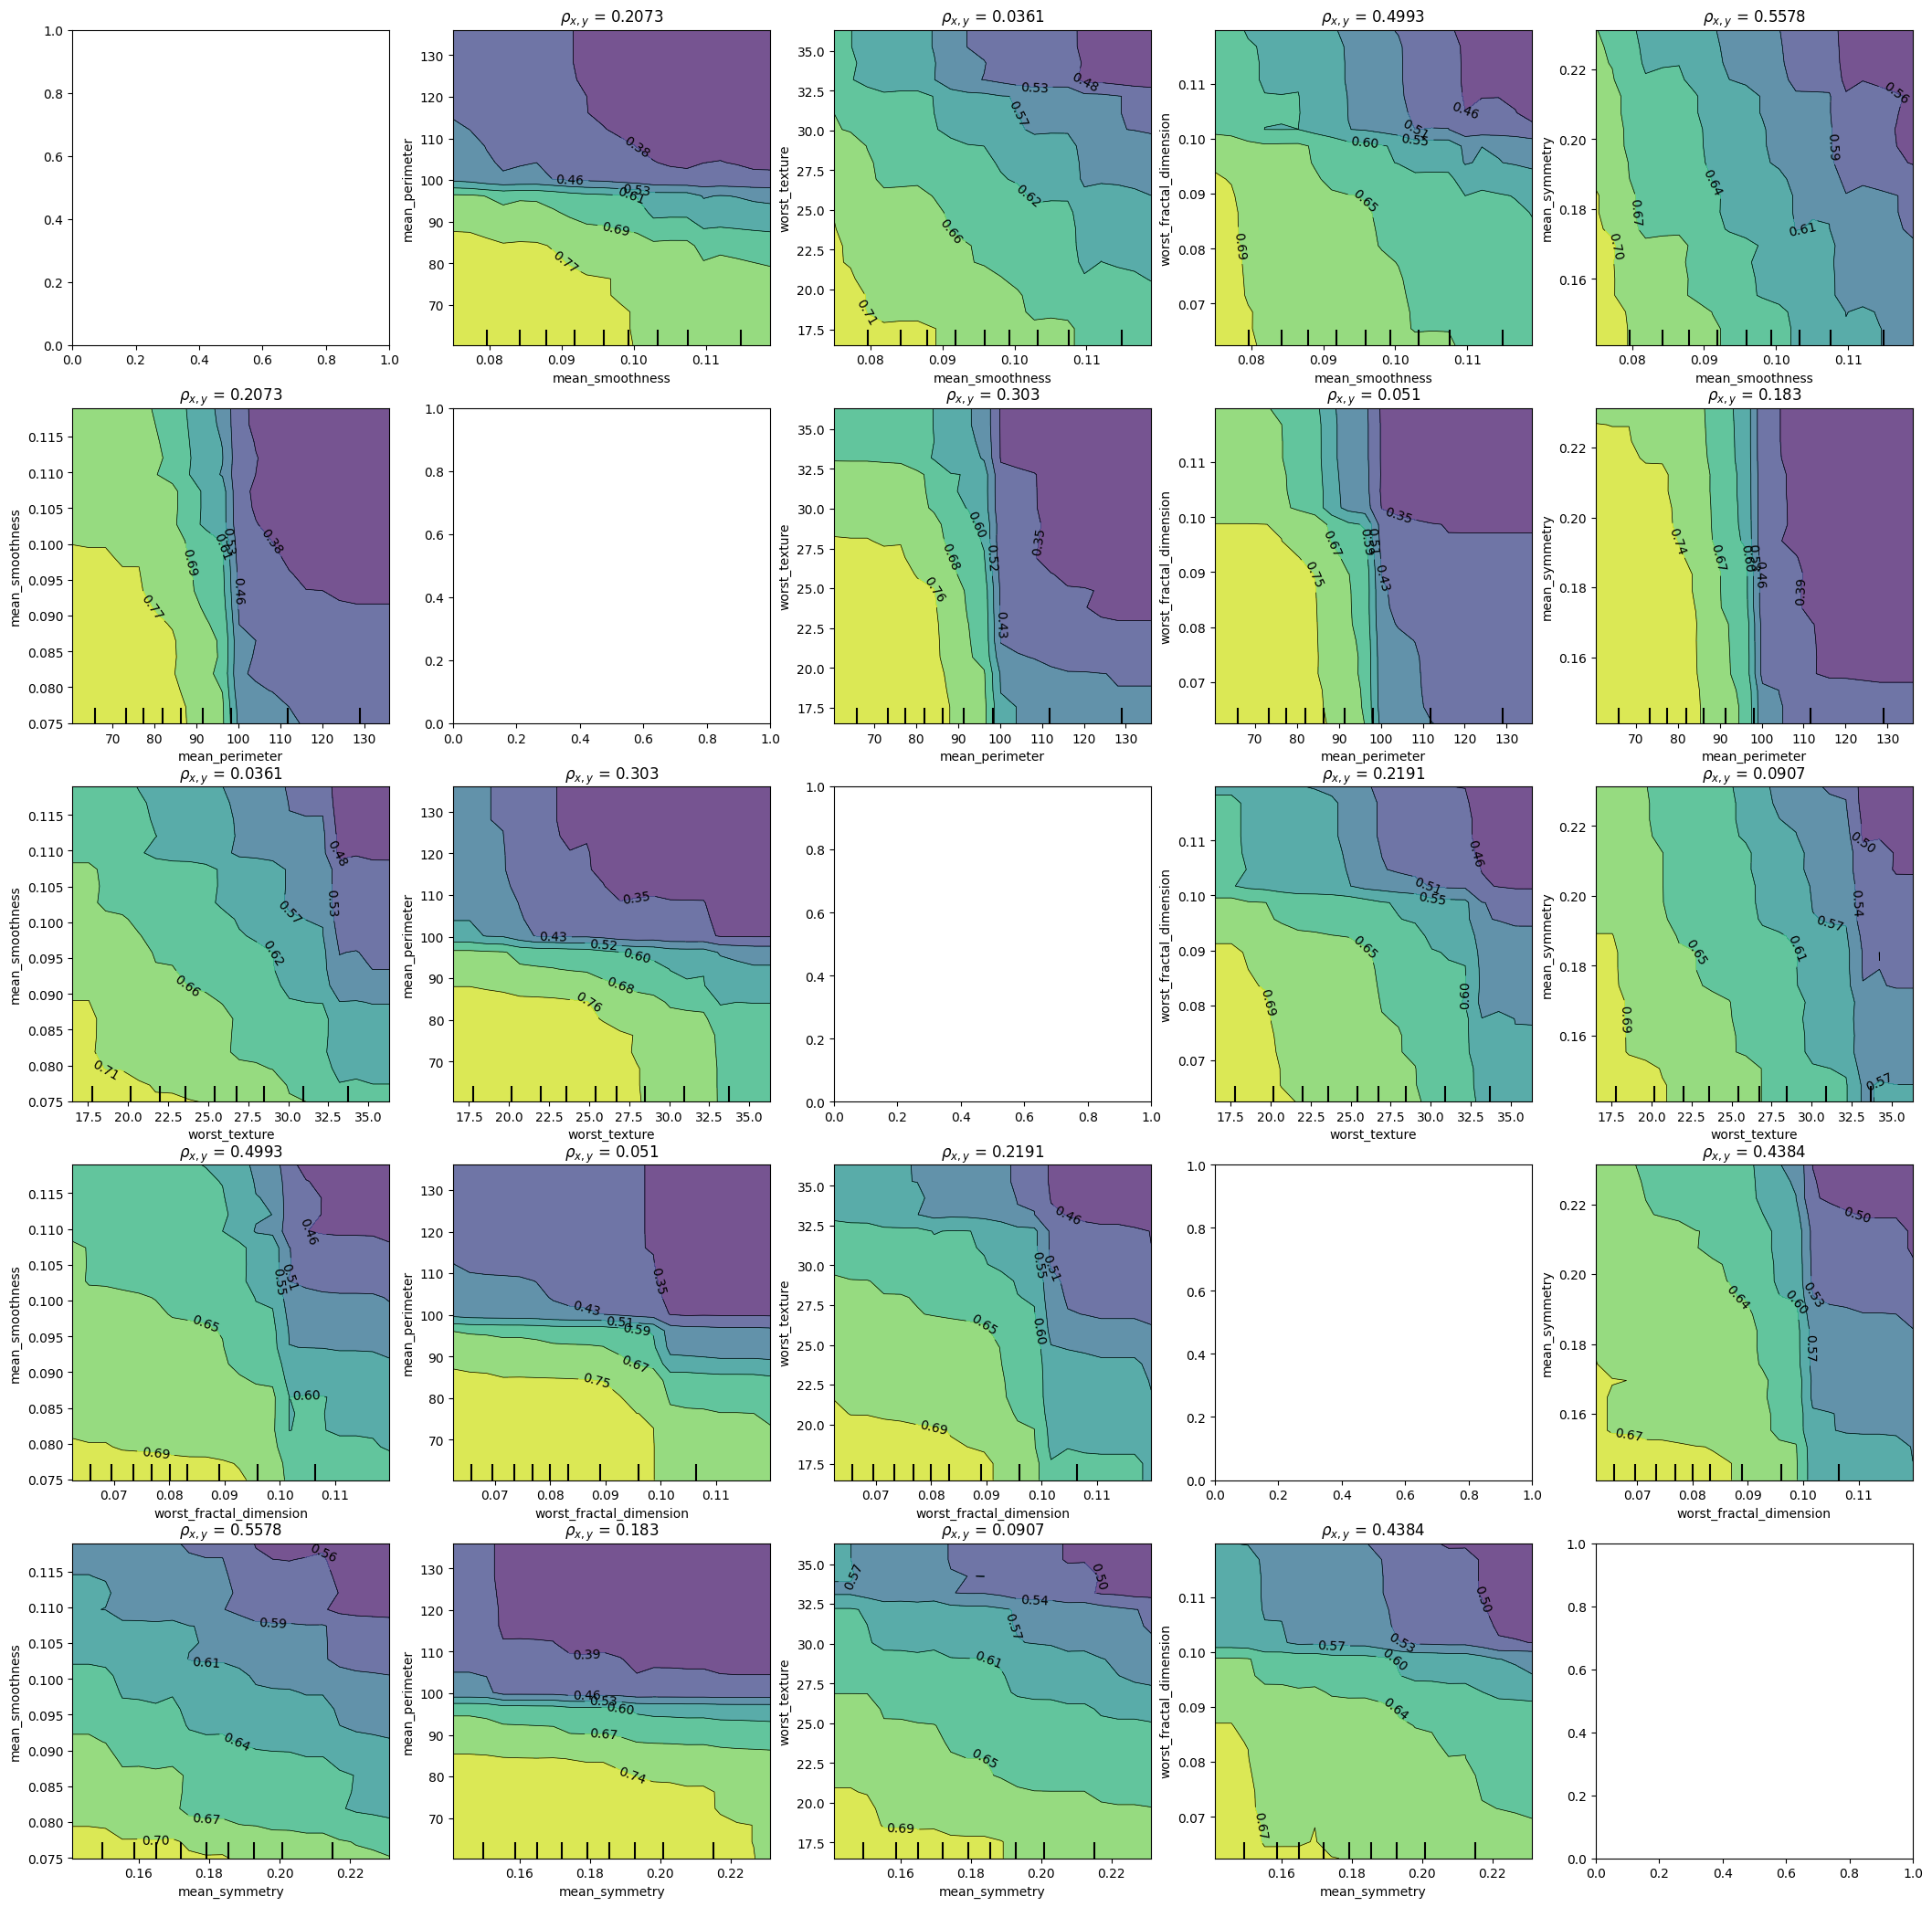

In [266]:
fig_pdp_m1, axes_pdp_m1 = create_pdp_subplots(selected_features, model, X_test_feats)

Ao olharmos o gráfico PDP acima, podemos notar ja que a relação entre o mean_symmetry e mean_perimeter, o valor do mean_erimeter independe do valor do mean_symmetry em geral, para definir se é maior ou menor a chance do cancer ser maligno, com excessão de valores maiores do mean_symmetry e menores do mean_perimeter, apresentando uma reducao da probabilidade do cancer ser maligno. Cenário um pouco similar para a relação entre mean_simmetry e worst_fractal_dimension, contudo da para notar que valores menores de ambas as variaveis, uma maior chance do tumor ser maligno, e o inverso é valido também, valores maiores de ambas reduzem a probabilidade do cancer ser maligno.


Alguns pares de variaveis acima, possuem um relacionamento importante, delas podemos listar:

1. **mean_smoothness x mean_symmetry**: aonde parece estar bem definido, para valores de mean_smoothness inferiores a 0.08 e menores que 0.19 aproximadamente, as chances sao maiores do cancer ser maligno, e quando aumentamos ambas as features, reduzimos as probabilidades.
2. **mean_smoothness x worst_texture**: cenário similar ao cenário *(1)* citado acima.
3. **worst_fractal_dimension x worst_texture**: temos uma fronteira de decisão ali perto de 0.1 para o worst_fractal_dimension e 30 para o worst_texture, aonde quanto maior para ambos, existe uma redução das probabilidades de ser maligno, contudo isso pode ser justificado pela baixa presenca de instancias com valores maiores em x; além disso, valores menores de ambos indicam um aumento da chance do tumor ser maligno.

## 7. Individual Conditional Expectation (ICE)

Abaixo vamos gerar algumas ICEs.

In [277]:
n_cols = 2
n_rows = 3
fig_ice, axes_ice = plt.subplots(n_rows, n_cols, figsize = (16, 16))
axes_ice = axes_ice.flatten()
for i, ax in zip(selected_features, axes_ice):
    disp1 = PartialDependenceDisplay.from_estimator(model, X_test_feats, [i], kind='both', ax=ax)

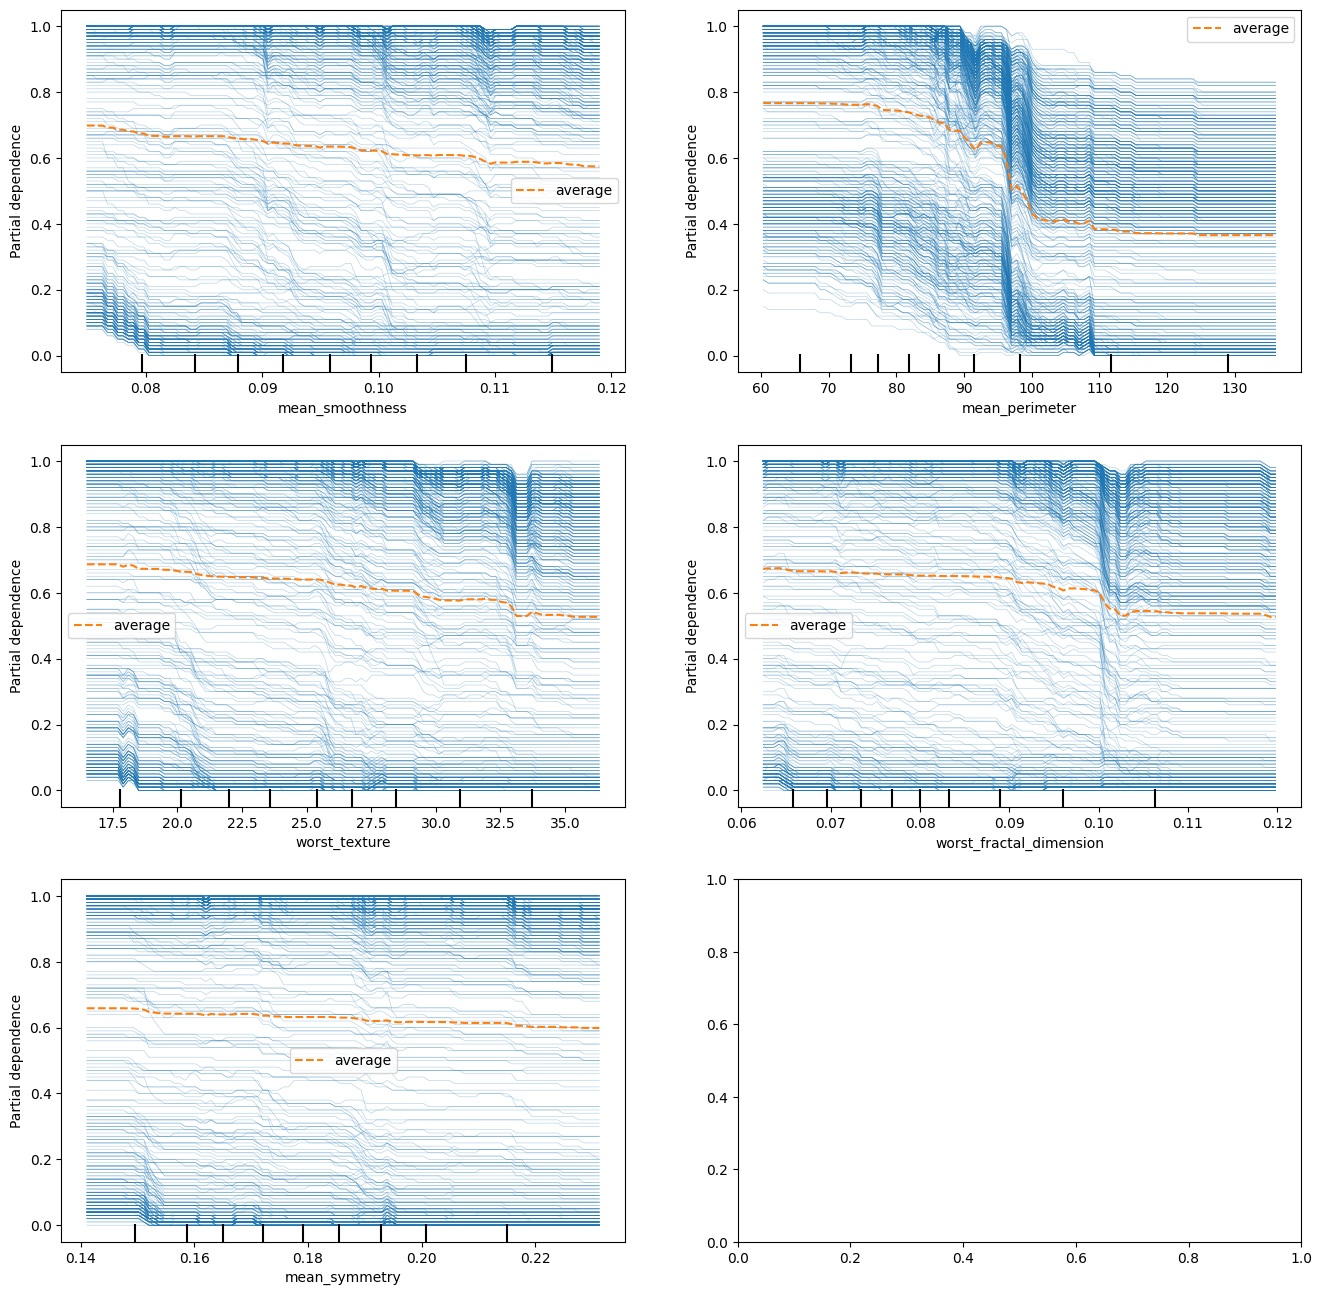

In [279]:
fig_ice

Focando apenas na variável mean_perimeter, podemos notar que o risco do cancer ser maligno reduz apartir de 75 de perimetro medio, com uma queda bem brusca dos valores. Além disso, podemos notar que apartir do ponto de corte de 100, o risco tende a ser constante, mas também podendo ser justificado pela baixa presença de instancias com valores maiores que esse;

## 8. Conclusão

Por fim, podemos notar apartir das métricas que o modelo mantem a robustes, com metricas proximas do modelo completo com todas as features, mesmo apos a seleção de features extritamente positivas. Apos isso, olhando para os PDPs, podemos notar a partial dependence entre pares de features não correlacionadas, tendo algumas com uma fronteira de decisão bem definida entre os tipos de canceres, isso é bastante significante para retirada de insights sobre como o modelo tomou certas decisões ao classificar as instâncias.

Para validação localmente, podemos ter o ICE de cada instância, validando as informações do PDP, aparentemente as instâncias seguem o mesmo comportamento em geral, com respeito a partial dependence.